In [1]:
# load packages
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as ss

ext_scripts_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/scripts')
os.chdir(ext_scripts_dir)

from nm_utils import remove_bad_subjects, load_2d

code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)

# importing custom functions
import clinics_desc_functions as custom

sns.set(rc={'figure.facecolor':'white'})

In [2]:
import prepare_models_for_analysis

model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

# where things are
main_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS')
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS/models')
os.makedirs(models_dir, exist_ok=True)
fsdata_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS/backup')
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/models/lifespan_57K_82sites')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)
out_dir = models_dir


Load FS info
-------------

In [3]:
v1_fs = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_thickness_1.txt'), sep=';')
v1_fs.index = [i.split('.')[-1][2:] for i in v1_fs['id']]
v1_fs = v1_fs.drop(columns= 'id')
v1_fs.sort_index(inplace=True)

In [4]:
v2_fs = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_thickness_2.txt'), sep=';')
v2_fs.index = [i.split('.')[-1][2:] for i in v2_fs['id']]
v2_fs = v2_fs.drop(columns= 'id')
v2_fs.sort_index(inplace=True)

In [5]:
if sum(v1_fs.index == v2_fs.index) == v1_fs.shape[0]:
    print('Indicies acoss the two dataframes are in sync!')

Indicies acoss the two dataframes are in sync!


Load clinics
-----------

In [12]:
corr_clin = pd.read_csv(os.path.join(fsdata_dir, 'CoRR_AggregatedPhenotypicData.csv'))
pk = [str(i) for i in corr_clin['SUBID']]
corr_clin.index = pk
corr_clin.sort_index(inplace=True)

corr_clin.rename(columns={'SEX':'sex', 'AGE_AT_SCAN_1':'age', 'SITE':'site'}, inplace=True)

In [13]:
# delete subjects that were not processed
del_from_clin = list(set(corr_clin.index.unique()) - set(v1_fs.index))
corr_clin = corr_clin.drop(index= del_from_clin)
corr_clin = corr_clin[corr_clin['SESSION']=='Baseline']

# relabel SEX to 0-females; 1-males
corr_clin['sex'] = corr_clin['sex'].replace({'1': '0', '2':'1'})
corr_clin['sex']= corr_clin['sex'].astype(int)

# change age to number
corr_clin['age'] = pd.to_numeric(corr_clin['age'])

In [14]:
# quality control - adding number of holes
v1_lh_eh = pd.read_csv(os.path.join(fsdata_dir,'v1_lh_euler_holes.txt'), sep=' ')
v2_lh_eh = pd.read_csv(os.path.join(fsdata_dir,'v2_lh_euler_holes.txt'), sep=' ')

v1_rh_eh = pd.read_csv(os.path.join(fsdata_dir,'v1_rh_euler_holes.txt'), sep=' ')
v2_rh_eh = pd.read_csv(os.path.join(fsdata_dir,'v2_rh_euler_holes.txt'), sep=' ')

pk = [str(i) for i in v1_lh_eh['SUBID']]
v1_lh_eh.index = pk
v1_rh_eh.index = pk
v1_lh_eh.drop(columns='SUBID', inplace=True)
v1_rh_eh.drop(columns='SUBID', inplace=True)

pk = [str(i) for i in v2_lh_eh['SUBID']]
v2_lh_eh.index = pk
v2_rh_eh.index = pk
v2_lh_eh.drop(columns='SUBID', inplace=True)
v2_rh_eh.drop(columns='SUBID', inplace=True)

# concatenate with clinics
corr_clin = pd.concat([corr_clin, v1_lh_eh], axis=1, join='inner')
corr_clin = pd.concat([corr_clin, v1_rh_eh], axis=1, join='inner')
corr_clin = pd.concat([corr_clin, v2_lh_eh], axis=1, join='inner')
corr_clin = pd.concat([corr_clin, v2_rh_eh], axis=1, join='inner')

v1_indices = ['v1_rh_holes', 'v1_lh_holes']
corr_clin['v1_euler'] = (corr_clin[v1_indices]*-2+2).sum(axis=1)/2
v1_indices = ['v2_rh_holes', 'v2_lh_holes']
corr_clin['v2_euler'] = (corr_clin[v1_indices]*-2+2).sum(axis=1)/2


In [17]:
# create sitenum for distinct sites
sites = corr_clin['site'].unique()
df_sites = corr_clin.groupby('site').agg('nunique')
df_sites['sitenum'] = range(1001,1001+len(sites))
dict_sites = df_sites['sitenum'].to_dict()
corr_clin['sitenum'] = corr_clin['site']
corr_clin['sitenum'].replace(dict_sites, inplace=True)

# Delete sites with less than 20 subjects
sites_pivot = corr_clin.groupby('site').agg('count')['SUBID']
sites_small = sites_pivot[sites_pivot<50].index # HERE PICK THE SITETS BASED ON THE NUMBER OF PARTICIPANTS

corr_clin = corr_clin.drop(index=corr_clin.iloc[np.where(corr_clin['site'].isin(sites_small))[0]].index)

# extract a list of unique site ids from the test set
site_ids_te =  sorted(set(corr_clin['site'].to_list()))

In [22]:
# COmpute median of euler number across sites
corr_melted = pd.melt(corr_clin, id_vars=['site'], value_vars=['v1_euler', 'v2_euler'], ignore_index=False)
ct = corr_melted.groupby('site').agg('median')

corr_clin['en_median'] = 0
for isite in corr_clin['site'].unique():
    corr_clin['en_median'].iloc[np.where(corr_clin['site']==isite)[0]] = ct[ct.index==isite]['value'][0]



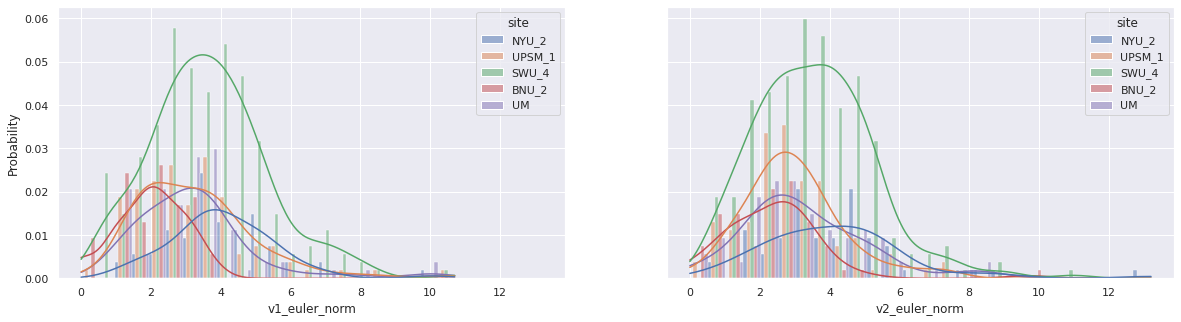

In [92]:
corr_clin['v1_euler_norm'] = np.sqrt(np.absolute((corr_clin['v1_euler']-corr_clin['en_median'])*(-1)))
corr_clin['v2_euler_norm'] = np.sqrt(np.absolute((corr_clin['v2_euler']-corr_clin['en_median'])*(-1)))

fig, ax = plt.subplots(1,2, figsize=(20,5), sharex=True, sharey=True)
sns.histplot(data= corr_clin, x='v1_euler_norm', hue='site', multiple='dodge', kde=True, ax=ax[0], stat='probability')
sns.histplot(data= corr_clin, x='v2_euler_norm', hue='site', multiple='dodge', kde=True, ax=ax[1], stat='probability')

# delete subjects with euler number over ten in any visit
corr_clin.drop(index = corr_clin[(corr_clin['v1_euler_norm']>10) | (corr_clin['v2_euler_norm']>10)].index, inplace=True)

In [94]:
# delete from v1_fs, v2_fs
del_from_fs = list(set(v1_fs.index) - set(corr_clin.index.unique()))
v1_fs = v1_fs.drop(index = del_from_fs)
v2_fs = v2_fs.drop(index = del_from_fs)

# add age and sex data to fs dataframes
v1_fs = pd.concat([v1_fs,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_fs = pd.concat([v2_fs,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

**Load additional metrics -- not necessary**

In [280]:
# Load other metrics
# gray matter volume
v1_gray_vol = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_GrayVol_1.txt'), sep=';')
v1_gray_vol.index = [i.split('.')[-1][2:] for i in v1_gray_vol['id']]
v1_gray_vol = v1_gray_vol.drop(columns= 'id')
v1_gray_vol.sort_index(inplace=True)

v2_gray_vol = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_GrayVol_2.txt'), sep=';')
v2_gray_vol.index = [i.split('.')[-1][2:] for i in v2_gray_vol['id']]
v2_gray_vol = v2_gray_vol.drop(columns= 'id')
v2_gray_vol.sort_index(inplace=True)

if sum(v1_gray_vol.index == v2_gray_vol.index) == v1_gray_vol.shape[0]:
    print('Gray matter volume: Indicies across the two dataframes are in sync!')

# Number of vertices
v1_num_ver = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_NumVert_1.txt'), sep=';')
v1_num_ver.index = [i.split('.')[-1][2:] for i in v1_num_ver['id']]
v1_num_ver = v1_num_ver.drop(columns= 'id')
v1_num_ver.sort_index(inplace=True)

v2_num_ver = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_NumVert_2.txt'), sep=';')
v2_num_ver.index = [i.split('.')[-1][2:] for i in v2_num_ver['id']]
v2_num_ver = v2_num_ver.drop(columns= 'id')
v2_num_ver.sort_index(inplace=True)

if sum(v1_num_ver.index == v2_num_ver.index) == v1_num_ver.shape[0]:
    print('Number of vertices: Indicies across the two dataframes are in sync!')

# Surface area
v1_surf_area = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_SurfArea_1.txt'), sep=';')
v1_surf_area.index = [i.split('.')[-1][2:] for i in v1_surf_area['id']]
v1_surf_area = v1_surf_area.drop(columns= 'id')
v1_surf_area.sort_index(inplace=True)

v2_surf_area = pd.read_csv(os.path.join(fsdata_dir,'fit_external_long_SurfArea_2.txt'), sep=';')
v2_surf_area.index = [i.split('.')[-1][2:] for i in v2_surf_area['id']]
v2_surf_area = v2_surf_area.drop(columns= 'id')
v2_surf_area.sort_index(inplace=True)

if sum(v1_surf_area.index == v2_surf_area.index) == v1_surf_area.shape[0]:
    print('Surface area: Indicies across the two dataframes are in sync!')

# concatenate with clinics
v1_gray_vol = pd.concat([v1_gray_vol,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_gray_vol = pd.concat([v2_gray_vol,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_num_ver = pd.concat([v1_num_ver,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_num_ver = pd.concat([v2_num_ver,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_surf_area = pd.concat([v1_surf_area,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')
v2_surf_area = pd.concat([v2_surf_area,corr_clin[['sex', 'age', 'site', 'sitenum']]],axis=1,join='inner')

v1_gray_vol.columns = v1_gray_vol.columns.str.replace('_GrayVol', '')
v2_gray_vol.columns = v2_gray_vol.columns.str.replace('_GrayVol', '')

v1_num_ver.columns = v1_num_ver.columns.str.replace('_NumVert', '')
v2_num_ver.columns = v2_num_ver.columns.str.replace('_NumVert', '')

v1_surf_area.columns = v1_surf_area.columns.str.replace('_SurfArea', '')
v2_surf_area.columns = v2_surf_area.columns.str.replace('_SurfArea', '')


Gray matter volume: Indicies across the two dataframes are in sync!
Number of vertices: Indicies across the two dataframes are in sync!
Surface area: Indicies across the two dataframes are in sync!


**Run Normative models**
-------------------------

In [96]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

####
# Getting a pretrained model
# ###
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [97]:
# redefine models dir path so that we don't overrite the results
models_dir = os.path.join(models_dir,'threshold_50')
os.makedirs(models_dir, exist_ok=True)
out_dir = models_dir
# visits
os.makedirs(os.path.join(out_dir,'V1'), exist_ok=True)
os.makedirs(os.path.join(out_dir, 'V2'), exist_ok=True)
os.makedirs(os.path.join(out_dir, 'img'), exist_ok=True)


In [98]:
# train_test_split - split across sites,
# adjusted adaptation routine:
#   - if a third of the dataset is smaller than 30 subjects, use 30 subjects anyway
#   - otherwise, use one third for adaptation

from sklearn.model_selection import train_test_split

index_split_ad = list()
index_split_te = list()

for i, isite in enumerate(site_ids_te):
    site_spec_ind = corr_clin.index[(corr_clin['site']==isite)]
    
    if i == 0:
        if len(site_spec_ind)*0.33 < 30:
            index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 50, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
        else:    
            index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 0.5, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
    else:
        if len(site_spec_ind)*0.33 < 30:
            b, a = train_test_split(site_spec_ind, test_size = 50, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])
        else:    
            b, a = train_test_split(site_spec_ind, test_size = 0.5, shuffle = True, random_state = 42, stratify=corr_clin[corr_clin['site']==isite][['sex']])

        index_split_ad = index_split_ad.append(a)
        index_split_te = index_split_te.append(b)


**Need to change the visit and run twice**

In [111]:
###
# Configure covariates
###
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# which visit to analyze?
which_visit = 2

# Pick the correct dataset for modelling
if which_visit == 1:
    df_ad = v1_fs.loc[index_split_ad]
    df_te = v1_fs.loc[index_split_te]
    df_ad.to_csv(os.path.join(models_dir,'V1','df_ad.csv'), sep=' ', index= True)
    df_te.to_csv(os.path.join(models_dir,'V1','df_te.csv'), sep=' ', index= True)

else:
    df_ad = v1_fs.loc[index_split_ad]
    df_te = v2_fs.loc[index_split_te]
    df_ad.to_csv(os.path.join(models_dir,'V2','df_ad.csv'), sep=' ', index= True)
    df_te.to_csv(os.path.join(models_dir,'V2','df_te.csv'), sep=' ', index= True)

In [ ]:
# Running the models
pretrained_adapt(idp_ids, site_ids_tr, site_ids_te, '/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts', os.path.join(out_dir, 'V'+str(which_visit)), df_ad, df_te)

**Run Normative models individually for every site**
----------------------------------------------------

In [10]:
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix

####
# Getting a pretrained model
# ###
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [11]:
# redefine models dir path so that we don't overrite the results
models_dir = os.path.join(models_dir,'individual_sites')
os.makedirs(models_dir, exist_ok=True)
out_dir = models_dir

# visits
#os.makedirs(os.path.join(out_dir,'V1'), exist_ok=True)
#os.makedirs(os.path.join(out_dir, 'V2'), exist_ok=True)
#os.makedirs(os.path.join(out_dir, 'img'), exist_ok=True)


In [12]:
# train_test_split - split across sites, keep 30% as training
from sklearn.model_selection import train_test_split

index_split_ad = list()
index_split_te = list()

for i, isite in enumerate(site_ids_te):
    site_spec_ind = corr_clin.index[(corr_clin['site']==isite)]
    
    os.makedirs(os.path.join(out_dir,isite), exist_ok=True)
    sitedir = os.path.join(out_dir,isite)
    os.makedirs(os.path.join(sitedir,'V1'), exist_ok=True)
    os.makedirs(os.path.join(sitedir, 'V2'), exist_ok=True)
       
    if i == 0:
        index_split_te, index_split_ad = train_test_split(site_spec_ind, test_size = 0.3, shuffle = False, random_state = 42)
        index_split_te = [index_split_te]
        index_split_ad = [index_split_ad]
    else:
        b, a = train_test_split(site_spec_ind, random_state = 42)
        index_split_ad.extend([a])
        index_split_te.extend([b])


**Need to change the visit and run twice**

In [22]:
###
# Configure covariates
###
# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# limits for cubic B-spline basis 
xmin = -5 
xmax = 110

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# which visit to analyze?
which_visit = 2

for i, isite in enumerate(site_ids_te):
    # Pick the correct dataset for modelling
    if which_visit == 1:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v1_fs.loc[index_split_te[i]]
        df_ad.to_csv(os.path.join(models_dir,isite,'V1','df_ad.csv'), sep=' ', index= True)
        df_te.to_csv(os.path.join(models_dir,isite,'V1','df_te.csv'), sep=' ', index= True)

    else:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v2_fs.loc[index_split_te[i]]
        df_ad.to_csv(os.path.join(models_dir,isite,'V2','df_ad.csv'), sep=' ', index= True)
        df_te.to_csv(os.path.join(models_dir,isite,'V2','df_te.csv'), sep=' ', index= True)


In [23]:
# We want to have the quality measures for all sites separately
# we won't get this if we run the models on all sites at once, so we need to do this one by one
pretrained_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/braincharts/')

for i, isite in enumerate(site_ids_te):
    if which_visit == 1:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v1_fs.loc[index_split_te[i]]
    else:
        df_ad = v1_fs.loc[index_split_ad[i]]
        df_te = v2_fs.loc[index_split_te[i]]

    visit_dir = os.path.join(models_dir, isite, 'V'+str(which_visit))
    custom.pretrained_adapt(idp_ids, site_ids_tr, isite, pretrained_dir, visit_dir, df_ad, df_te)
    #      pretrained_adapt(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_te)

Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 lh_G&S_subcentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 lh_G&S_transv_frontopol_thickness :
Some sites missing from the training data. Adapt

**Evaluate the quality of fit**

In [403]:
# WIDE
# Concatenate the quality of fit across all sites and both visits
for insite, isite in enumerate(site_ids_te):
    for ivisit in range(1,3):
        
        temp, nothing = custom.idp_concat_quality(os.path.join(models_dir, isite, 'V'+str(ivisit)), idp_ids)
        temp = temp.add_prefix(isite+'_')
        temp = temp.add_suffix('_'+str(ivisit))

        if (insite==0) & (ivisit ==1):
            q_data_w = temp
        else:
            q_data_w = pd.concat([q_data_w,temp], axis=1)

In [75]:
# LONG
# Concatenate the quality of fit across all sites and both visits
for insite, isite in enumerate(site_ids_te):
    for ivisit in range(1,3):
        
        temp, nothing = custom.idp_concat_quality(os.path.join(models_dir, isite, 'V'+str(ivisit)), idp_ids)
        temp['visit'] = ivisit
        temp['site'] = isite

        if (insite==0) & (ivisit ==1):
            q_data = temp
        else:
            q_data = pd.concat([q_data,temp], axis=0)

q_data['roi'] = q_data.index
q_data.index=range(q_data.shape[0])

**A lot of pictures here**

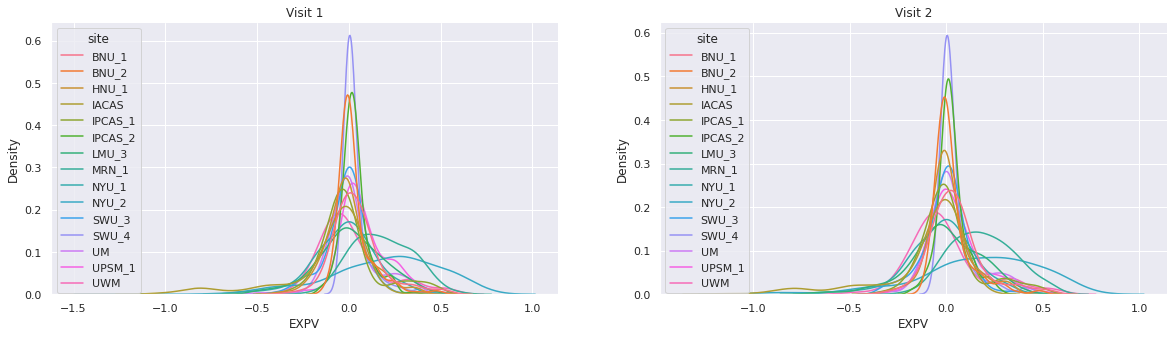

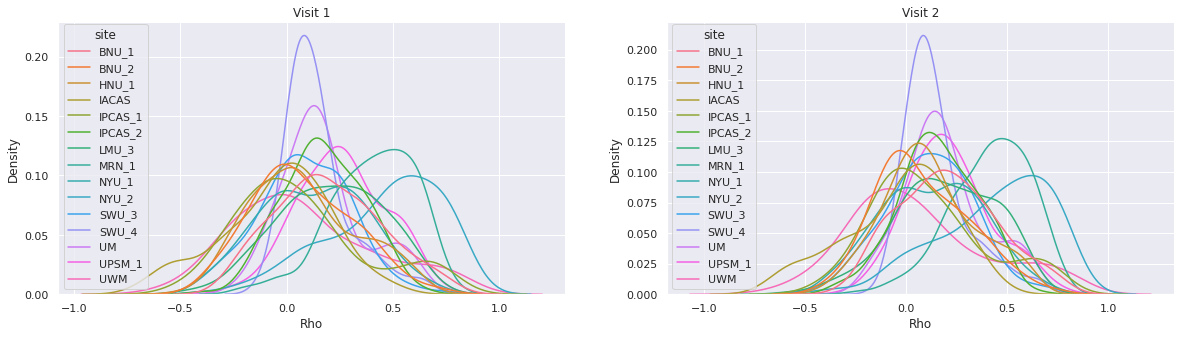

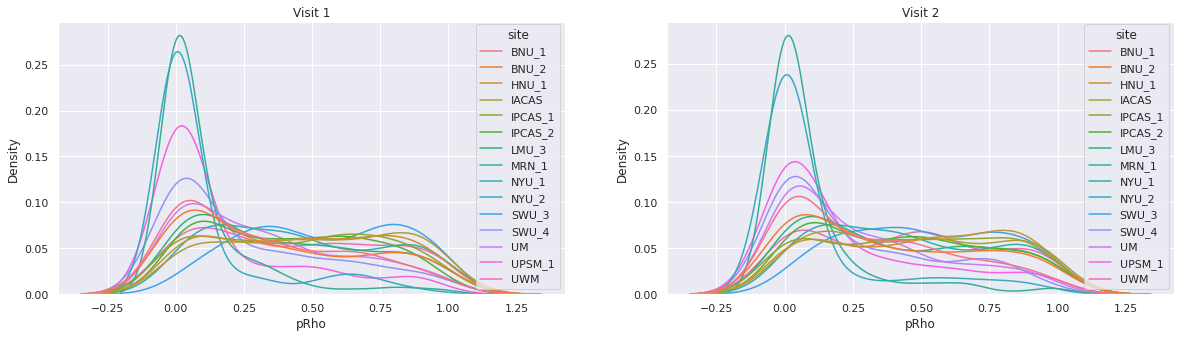

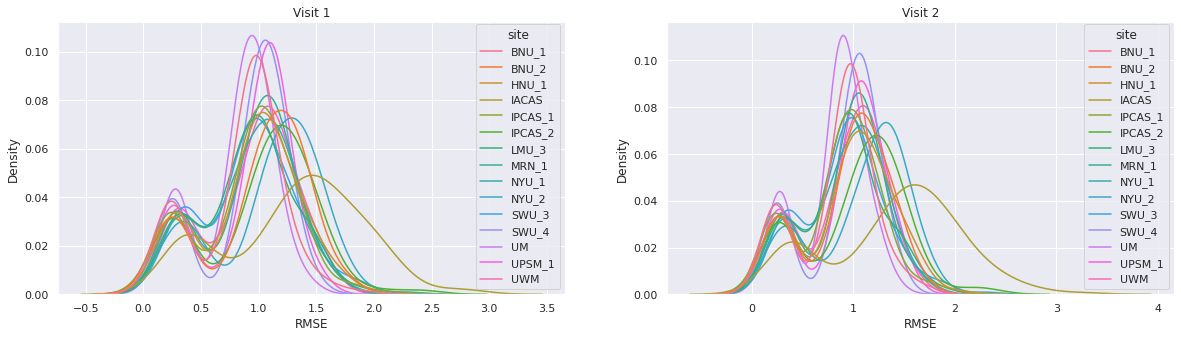

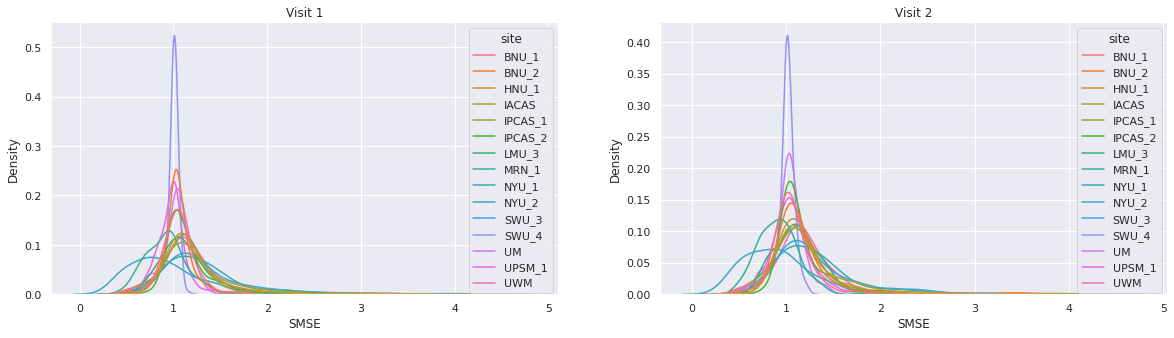

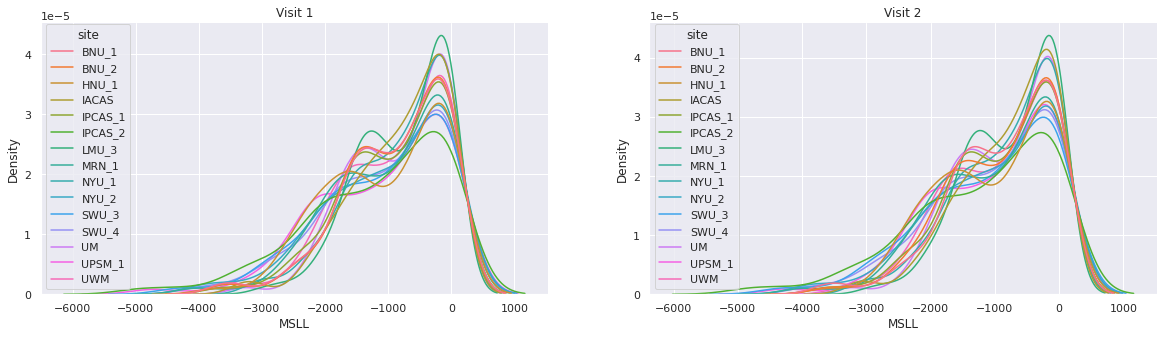

In [472]:
# Smoothed histograms
quality_measures = ['EXPV', 'Rho', 'pRho', 'RMSE', 'SMSE', 'MSLL']

for iqual in quality_measures:
    fix, ax = plt.subplots(1,2,figsize=(20,5))
    sns.kdeplot(data=q_data[q_data['visit']==1], x=iqual, hue='site', ax=ax[0])
    ax[0].set_title('Visit 1')
    sns.kdeplot(data=q_data[q_data['visit']==2], x=iqual, hue='site', ax=ax[1])
    ax[1].set_title('Visit 2')
    sns.despine()
    plt.savefig(os.path.join(images_dir,iqual))

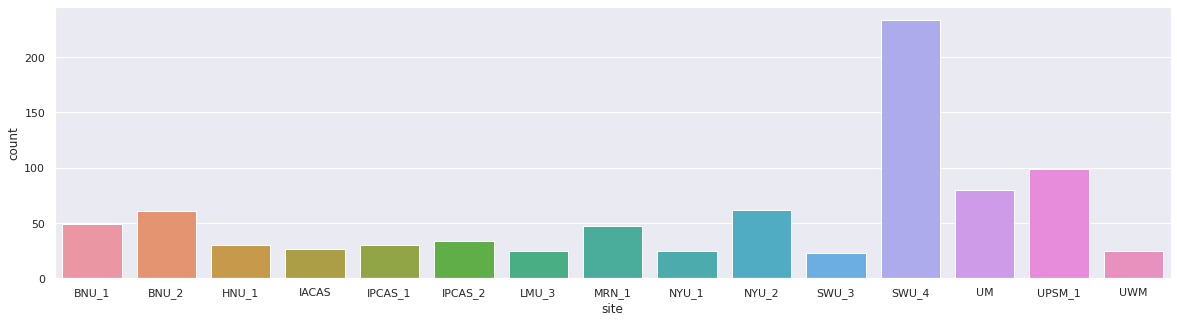

In [391]:
# Juts plot the counts
fix, ax = plt.subplots(1,1,figsize=(20,5))
sns.countplot(data=v1_fs, x='site', order=v1_fs['site'].value_counts().sort_index().index)
plt.savefig(os.path.join(images_dir, 'site_counts'))

In [358]:
# Let's try to modelthe Explained variance for example
q_data['subjects'] = 0
q_data['females'] = 0

q_data['av_size'] = 0
q_data['av_size_f'] = 0
q_data['av_size_m'] = 0

q_data['av_gmv'] = 0
q_data['av_gmv_f'] = 0
q_data['av_gmv_m'] = 0

q_data['av_numv'] = 0
q_data['av_numv_f'] = 0
q_data['av_numv_m'] = 0

q_data['av_area'] = 0
q_data['av_area_f'] = 0
q_data['av_area_m'] = 0

q_data['a_025_f'] = 0
q_data['a_025_m'] = 0
q_data['a_025'] = 0

q_data['a_05_f'] = 0
q_data['a_05_m'] = 0
q_data['a_05'] = 0

q_data['a_075_f'] = 0
q_data['a_075_m'] = 0
q_data['a_075'] = 0


idp_ids_strip = [i.replace('_thickness', '') for i in idp_ids]

# create variables we want to use for modelling
for isite in site_ids_te:
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'subjects'] = v1_fs[v1_fs['site']==isite].shape[0]
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'females'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==0)].shape[0]

    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.25)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.25)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_025'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.25)
    
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.5)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.5)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_05'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.5)

    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075_f'] = v1_fs[(v1_fs['sex']==0) & (v1_fs['site']==isite)]['age'].quantile(0.75)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075_m'] = v1_fs[(v1_fs['sex']==1) & (v1_fs['site']==isite)]['age'].quantile(0.75)
    q_data.loc[q_data.iloc[np.where(q_data['site']==isite)[0]].index, 'a_075'] = v1_fs[v1_fs['site']==isite]['age'].quantile(0.75)
    
    
    for idp in idp_ids:
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size'] = v1_fs[(v1_fs['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size_f'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp))[0]].index, 'av_size_m'] = v1_fs[(v1_fs['site']==isite) & (v1_fs['sex']==1)][idp].mean()

    for i, idp in enumerate(idp_ids_strip):
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv'] = v1_gray_vol[(v1_gray_vol['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv_f'] = v1_gray_vol[(v1_gray_vol['site']==isite) & (v1_gray_vol['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_gmv_m'] = v1_gray_vol[(v1_gray_vol['site']==isite) & (v1_gray_vol['sex']==1)][idp].mean()

        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv'] = v1_num_ver[(v1_num_ver['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv_f'] = v1_num_ver[(v1_num_ver['site']==isite) & (v1_num_ver['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_numv_m'] = v1_num_ver[(v1_num_ver['site']==isite) & (v1_num_ver['sex']==1)][idp].mean()

        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area'] = v1_surf_area[(v1_surf_area['site']==isite)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area_f'] = v1_surf_area[(v1_surf_area['site']==isite) & (v1_surf_area['sex']==0)][idp].mean()
        q_data.loc[q_data.iloc[np.where((q_data['site']==isite) & (q_data['roi']==idp_ids[i]))[0]].index, 'av_area_m'] = v1_surf_area[(v1_surf_area['site']==isite) & (v1_surf_area['sex']==1)][idp].mean()



# some ROIs are inherently badly fitted, find which they are and delete them from all sites and visits
rois_to_drop = q_data[np.isnan(q_data['Rho'])]['roi'].unique()
print('rows that contain following ROI: ' +rois_to_drop+ ' will be deleted')
q_data.drop(index=q_data[q_data['roi'].isin(rois_to_drop)].index, inplace=True)
q_data['roi'] = q_data['roi'].astype('category')

[]


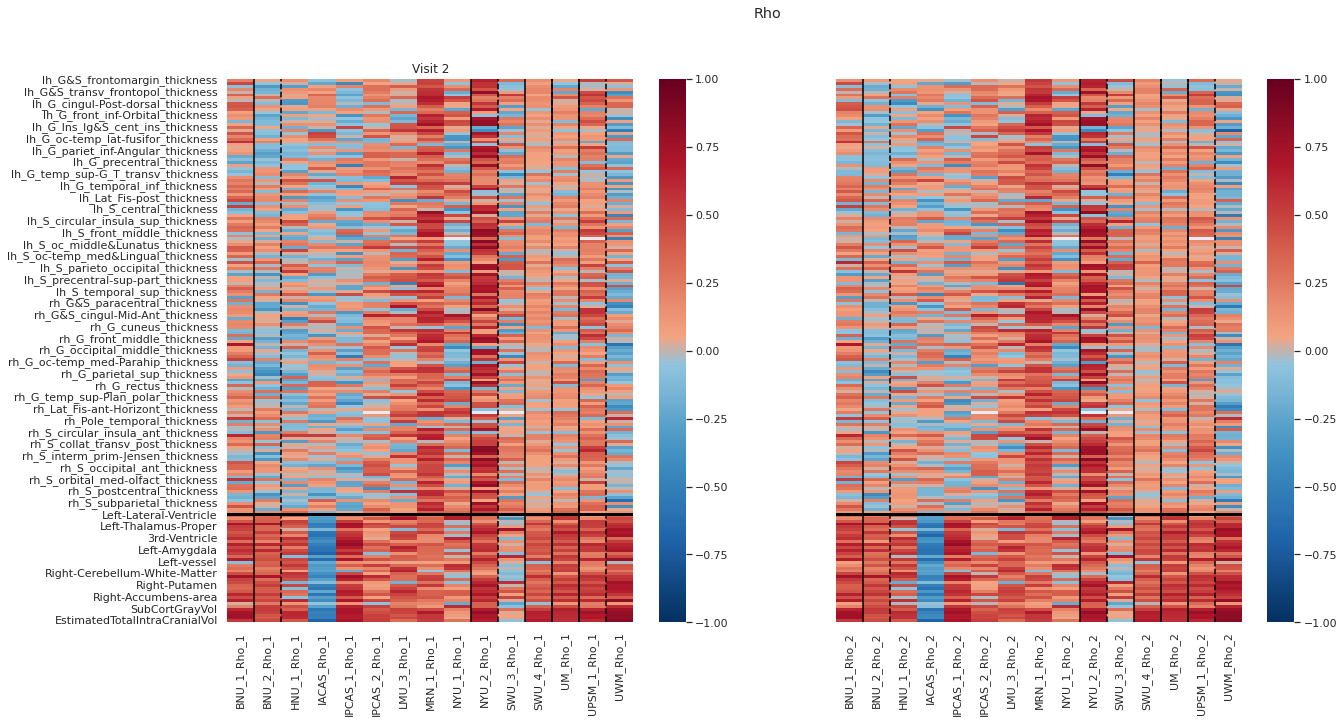

In [470]:
# Heatmaps across idps and quality measures
import matplotlib 
# preparation of colorscales
n = 10
orig_cmap = plt.cm.RdBu_r
colors1 = orig_cmap(np.linspace(0, 0.3, n))
colors2 = orig_cmap(np.linspace(0.7, 1, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", np.vstack([colors1,colors2]))

line_id = np.where(v1_fs['site'].value_counts().sort_index()>50)[0]
quality_measures = ['EXPV', 'Rho', 'pRho', 'RMSE', 'SMSE', 'MSLL']

# plotting
for iscale in [quality_measures[1]]:

    id1 = [i for i in q_data_w.columns if '_'+iscale+'_1' in i]
    id2 = [i for i in q_data_w.columns if '_'+iscale+'_2' in i]

    fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True)
    sns.heatmap(q_data_w[id1], cmap=cmap, vmin=-1, vmax=1, ax=ax[0])
    sns.heatmap(q_data_w[id2], cmap=cmap, vmin=-1, vmax=1, ax=ax[1])
    ax[0].axhline(len(thick_id), linewidth=3, color='black')
    ax[1].axhline(len(thick_id), linewidth=3, color='black')

    for iline in line_id:
        ax[0].axvline(iline, color='black')
        ax[0].axvline(iline+1, color='black', linestyle='--')
        ax[1].axvline(iline, color='black')
        ax[1].axvline(iline+1, color='black', linestyle='--')

    ax[0].set_title('Visit 1')
    ax[0].set_title('Visit 2')
    fig.suptitle(iscale)
    plt.savefig(os.path.join(images_dir,'heatmap_'+iscale))

In [360]:
# split the quality measures to thicknesses and volumes

thick_id = [i for i in v1_fs.columns if 'thickness' in i]
sc_id= [i for i in idp_ids if 'thickness' not in i]

q_data_thick = q_data[(q_data['roi'].isin(thick_id))]
q_data_sc = q_data[(q_data['roi'].isin(sc_id))]


**Mixed models to analyze the performance measures**

In [361]:
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf

mm_thick = smf.mixedlm("EXPV~ females + subjects + av_size + C(visit, Treatment(1))",
                    q_data_thick,
                    groups= "site").fit()

mm_thick_big = smf.mixedlm("EXPV~ females + subjects + av_size + C(visit, Treatment(1)) + av_gmv + av_numv + av_area",
                    q_data_thick,
                    groups= "site").fit()

mm_thick_big2 = smf.mixedlm("EXPV~ females + subjects + C(visit, Treatment(1)) + av_area_f + av_area_m + av_numv_f + av_numv_m + av_size_f + av_size_m + av_gmv_f +  av_gmv_m",
                    q_data_thick,
                    groups= "site").fit()

                    

mm_sc = smf.mixedlm("EXPV~ females + subjects + av_size_f + av_size_m + C(visit, Treatment(1))",
                    q_data_sc,
                    groups= "site").fit()




/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Analysis
--------

**Load the values across idps and visits and compare across sites**

In [11]:
models_dir = os.path.join('/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/')
cols_cov = ['age','sex']

In [12]:
v1_z = custom.idp_concat(os.path.join(models_dir,'V1'), 'Z_predict.txt', idp_ids, 'CORR_V1_Z.csv', t_dir= models_dir)
v2_z = custom.idp_concat(os.path.join(models_dir,'V2'), 'Z_predict.txt', idp_ids, 'CORR_V2_Z.csv', t_dir= models_dir)

v1_z = pd.read_csv(v1_z, sep = ' ')
v2_z = pd.read_csv(v2_z, sep = ' ')

In [13]:
# load the test-retest data
v1_orig = pd.read_csv(os.path.join(models_dir, 'V1', 'df_te.csv'), sep=' ', index_col=0)
v2_orig = pd.read_csv(os.path.join(models_dir, 'V2', 'df_te.csv'), sep=' ', index_col=0)

# load the ESO controls data 
v1_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v1_cont.txt'), sep=' ', index_col=0)
v2_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v2_cont.txt'), sep=' ', index_col=0)

v1_cont['sitenum'] = 1000
v2_cont['sitenum'] = 1000

In [14]:
v1_z.index = v1_orig.index
v1_z['site'] = v1_orig['site']
v1_z['sitenum'] = v1_orig['sitenum']
v1_z['age'] = v1_orig['age']
v1_z['sex'] = v1_orig['sex']

v2_z.index = v2_orig.index
v2_z['site'] = v1_orig['site']
v2_z['age'] = v1_orig['age']
v2_z['sex'] = v1_orig['sex']
v2_z['sitenum'] = v1_orig['sitenum']

# adding ESO data
v1_z_all = pd.concat([v1_z[idp_ids+ cols_cov+['site', 'sitenum']], v1_cont[idp_ids+ cols_cov+['site', 'sitenum']]])
v2_z_all = pd.concat([v2_z[idp_ids+ cols_cov+['site', 'sitenum']], v2_cont[idp_ids+ cols_cov+['site', 'sitenum']]])

# diff
diff = v2_z_all[idp_ids] - v1_z_all[idp_ids]
diff['site'] = v1_z_all['site']
diff['sitenum'] = v1_z_all['sitenum']
diff['sex'] = v1_z_all['sex']

**Visualization**

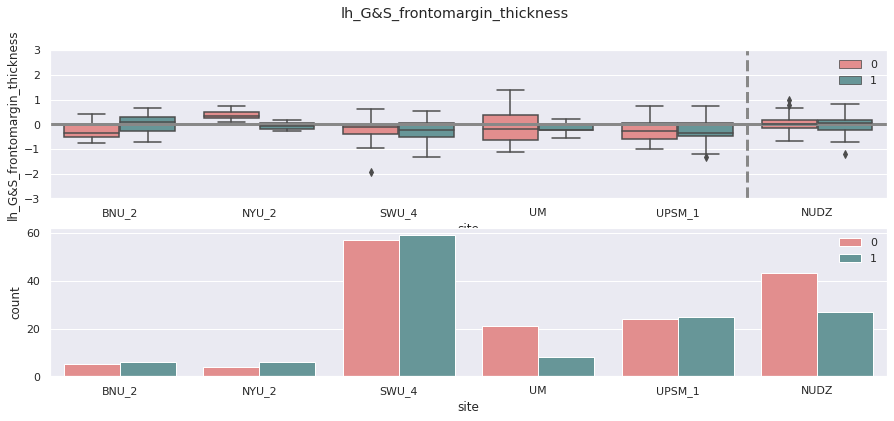

In [117]:
# Plotting differences between visits across sites with respect to sex

FM_colors = ["lightcoral", "cadetblue"]
cp = sns.set_palette(sns.color_palette(FM_colors))


for idp in [idp_ids[0]]:
    fig, ax = plt.subplots(2,1,figsize=(15,6))
    ax[0] = sns.boxplot(x="site", y=idp, data=diff, hue='sex', palette = cp, ax=ax[0])
    ax[0].set(ylim=(-3, 3))
    ax[0].legend(frameon=False)
#    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30)
    ax[0].axhline(0, linewidth = 3, color='#888888')
    ax[0].axvline(diff["site"].nunique()-1.5, linewidth = 3, color='#888888', linestyle='--')

    ax[1] = sns.countplot(data=diff, x='site', hue='sex')
    ax[1].legend(frameon=False)
    fig.suptitle(idp)

    #plt.savefig(os.path.join(models_dir, 'img',idp),  bbox_inches='tight')
    #plt.close()

In [47]:
images_dir

'/home/barbora/Documents/Projects/Normative_Models/COINS/models/img'

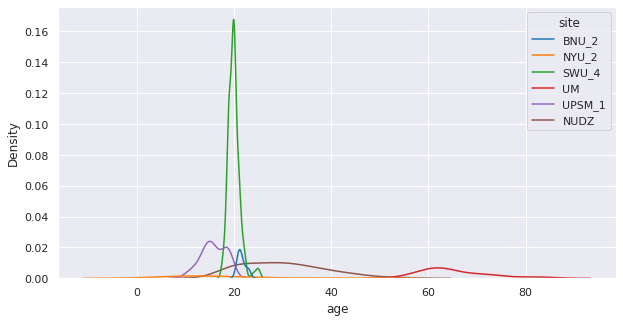

In [49]:
models_dir = ('/home/barbora/Documents/Projects/Normative_Models/COINS/models')
images_dir = os.path.join(models_dir, 'threshold_50','img')

# Distribution of age by site
fig = plt.figure(figsize=(10,5))
ax = sns.kdeplot(data=v1_z_all, x='age', hue='site')
plt.savefig(os.path.join(images_dir, 'age_dist'))

**HBR -- modelling site-specific intercepts**
------------------------------------------------

In [19]:
import pymc3 as pm
import arviz as az

In [17]:
diff['hbr_sitenum'] = pd.factorize(diff['site'])[0]

In [24]:
# Define Hierarchical Bayesian Regression (using PYMC3)
temp = np.empty([len(idp_ids),3])

for iidp, idp in enumerate(idp_ids):

    with pm.Model() as hier_model:
        
        # underlying distribution for all sites (only for intercept now)
        mu_a = pm.Normal("mu_a", 0, 1)
        sigma_a = pm.Exponential("sigma_a", 1/2)

        # site specific intercept
        alpha = pm.Normal("alpha", mu_a, sigma_a, shape=diff['hbr_sitenum'].nunique())
        
        # model
        mu = alpha[diff['hbr_sitenum']]
        sigma = pm.Exponential("sigma", 1/2)

        y = pm.Normal('y', mu, sigma, observed=diff[idp])
        trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

    pk = pk = az.summary(trace)
    temp[iidp,:] = np.array([pk['mean'].loc['alpha[5]'], pk['mean'].loc['sigma_a'], pk['mean'].loc['mu_a']])

    if (np.mod(iidp, 10) == 0) & (iidp!=0) :
        np.savetxt(os.path.join(models_dir, 'BHR_temp.csv'), temp, delimiter=' ')

pd.DataFrame(temp, index = idp_ids, columns=['mean', 'var', 'alpha_mean']).to_csv(os.path.join(models_dir, 'BHR.csv'), sep=' ')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8290147666377327, but should be close to 0.9. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8391661546342993, but should be close to 0.9. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8281706873961391, but should be close to 0.9. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8068863471907377, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6179956289543025, but should be close to 0.9. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8155727306270729, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7818643131865723, but should be close to 0.9. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6999037787161009, but should be close to 0.9. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8264137435348642, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7727189693029084, but should be close to 0.9. Try to increase the number of tuning steps.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8209857264082493, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8052473305263838, but should be close to 0.9. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.830320145204814, but should be close to 0.9. Try to increase the number of tuning steps.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8292455819893189, but should be close to 0.9. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7950090353888841, but should be close to 0.9. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7420481906802632, but should be close to 0.9. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7993333403510391, but should be close to 0.9. Try to increase the number of tuning steps.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7875015919142124, but should be close to 0.9. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8280766880856429, but should be close to 0.9. Try to increase the number of tuning steps.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7728791103434581, but should be close to 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 66 seconds.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7769912942327544, but should be close to 0.9. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8363954354947586, but should be close to 0.9. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.829951484279233, but should be close to 0.9. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8249276498992507, but should be close to 0.9. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8401057434701037, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
I

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7792728259320963, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7202470186426893, but should be close to 0.9. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8406774607073358, but should be close to 0.9. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.839459623459842, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS s

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7411588973415073, but should be close to 0.9. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8150210192905655, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.75039214769626, but should be close to 0.9. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/pymc3/model.py:1668: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 77 seconds.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8357515556909644, but should be close to 0.9. Try to increase the number of tuning steps.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7768298080239843, but should be close to 0.9. Try to increase the number of tuning steps.
There were 196 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8104108068827106, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NU

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8250543879311814, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8231632478815167, but should be close to 0.9. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 553 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39627196930612707, but should be close to 0.9. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7865569122120433, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7676598904232508, but should be close to 0.9. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7160092576946229, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8155047813655385, but should be close to 0.9. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7103249761424866, but should be close to 0.9. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 48 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 66 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8068434348971864, but should be close to 0.9. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8221977511808969, but should be close to 0.9. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8327082299682976, but should be close to 0.9. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8205673371723317, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.807123898443064, but should be close to 0.9. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7206787141123381, but should be close to 0.9. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7963370731315199, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8405391240405856, but should be close to 0.9. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8061506581434235, but should be close to 0.9. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8097168131252881, but should be close to 0.9. Try to increase the number of tuning steps.
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7715124267379796, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler..

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7538686764227157, but should be close to 0.9. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/pymc3/model.py:1668: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_missing, sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 377 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6656900187717502, but should be close to 0.9. Try to increase the number of tuning steps.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8336077266614316, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+a

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8336217769148812, but should be close to 0.9. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7783573293473389, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8410146102321249, but should be close to 0.9. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.824473487230727, but should be close to 0.9. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8227668140593687, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8393029814901558, but should be close to 0.9. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8374449822044583, but should be close to 0.9. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.787298719285903, but should be close to 0.9. Try to increase the number of tuning steps.
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8159535315495978, but should be close to 0.9. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 48 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8263526286539749, but should be close to 0.9. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8021829163069065, but should be close to 0.9. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 63 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7709742694837344, but should be close to 0.9. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 1089 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3335718469014839, but should be close to 0.9. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 202 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961759082805321, but should be close to 0.9. Try to increase the number of tuning steps.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.833631622966685, but should be close to 0.9. Try to increase the number of tuning steps.
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7397637785983245, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7987207634143367, but should be close to 0.9. Try to increase the number of tuning steps.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7340750967171341, but should be close to 0.9. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8319190240559657, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 21 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 33 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8161875487745724, but should be close to 0.9. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8279969466906486, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 35 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8020602610840615, but should be close to 0.9. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8158801696906481, but should be close to 0.9. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 36 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.786550032129849, but should be close to 0.9. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7674177604853485, but should be close to 0.9. Try to increase the number of tuning steps.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8350370045798464, but should be close to 0.9. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8332446853708969, but should be close to 0.9. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.


FileNotFoundError: [Errno 2] No such file or directory: '/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/threshold_50/BHR.csv'

In [25]:
pd.DataFrame(temp, index = idp_ids, columns=['mean', 'var', 'alpha_mean']).to_csv(os.path.join(models_dir, 'BHR.csv'), sep=' ')

In [22]:
np.savetxt(os.path.join(models_dir, 'BHR_temp.csv'), temp, delimiter=' ')

In [27]:
with pm.Model() as hier_model:
        
        # underlying distribution for all sites (only for intercept now)
        mu_a = pm.Normal("mu_a", 0, 1)
        sigma_a = pm.Exponential("sigma_a", 1/2)

        # site specific intercept
        alpha = pm.Normal("alpha", mu_a, sigma_a, shape=diff['hbr_sitenum'].nunique())
        
        # model
        mu = alpha[diff['hbr_sitenum']]
        sigma = pm.Exponential("sigma", 1/2)

        y = pm.Normal('y', mu, sigma, observed=diff[idp_ids[0]])
        trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
images_dir

'/home/barbora/Documents/Projects/Normative_Models/COINS/models/img'

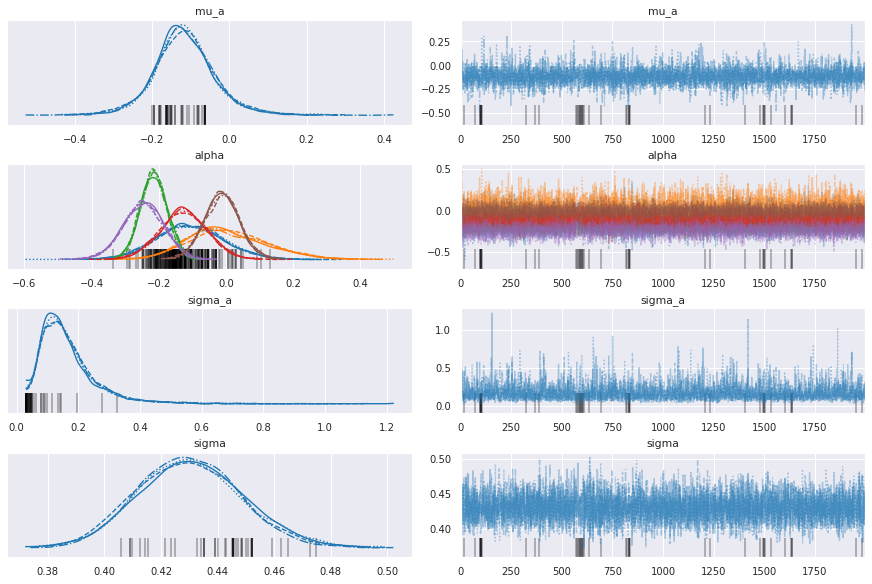

In [30]:
import arviz as az
sns.set_palette('tab10')
az.plot_trace(trace)    
plt.savefig(os.path.join(images_dir,'BHR_trace'))

<AxesSubplot:ylabel='Count'>

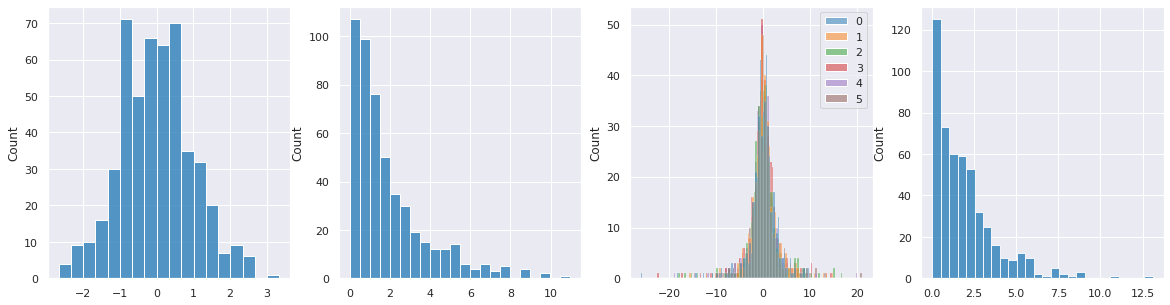

In [214]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.histplot(prior['mu_a'], ax = ax[0])
sns.histplot(prior['sigma_a'], ax = ax[1])
sns.histplot(prior['alpha'], ax = ax[2])
sns.histplot(prior['sigma'], ax = ax[3])

In [127]:
# save statistics for NUDZ (not taking ther sites into consideration)
pk = diff[[*idp_ids,'site']].groupby('site').agg(['mean', 'var']).stack()
pk = pk.loc['NUDZ',:].T
pk.to_csv(os.path.join(models_dir, 'threshold_50', 'NUDZ_alone_stat.csv'), sep=' ')

# Here we are saving statistics for the whole test-retest dataset (not taking the site into consideration)
pk = diff[[*idp_ids,'site']].agg(['mean', 'var']).T
pk.to_csv(os.path.join(models_dir, 'threshold_50', 'NUDZ_all_stat.csv'), sep=' ')

In [16]:
with hier_model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

<AxesSubplot:ylabel='Count'>

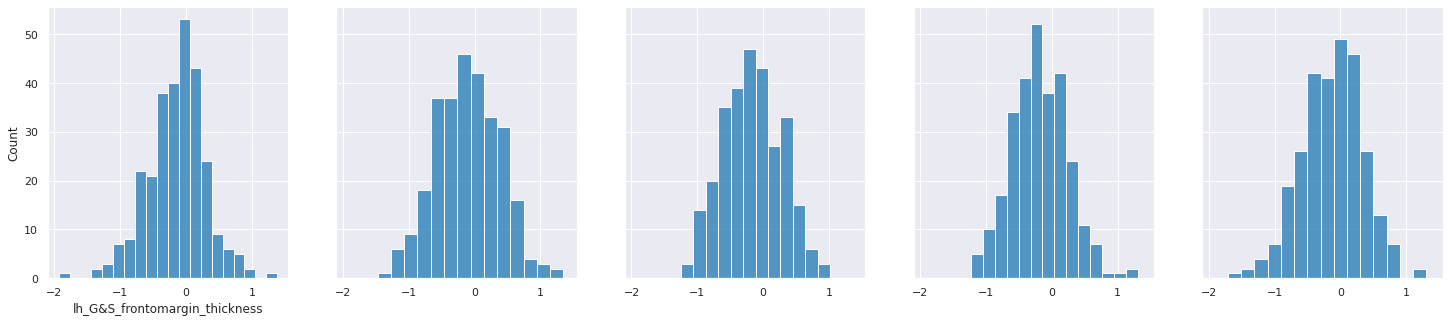

In [257]:
fig, ax = plt.subplots(1,5, figsize=(25,5), sharex = True, sharey=True)
sns.histplot(diff[idp_ids[0]], ax = ax[0])
sns.histplot(posterior_predictive['y'][int(np.round(np.random.rand(1)*10)[0]),:], ax = ax[1])
sns.histplot(posterior_predictive['y'][int(np.round(np.random.rand(1)*10)[0]),:], ax = ax[2])
sns.histplot(posterior_predictive['y'][int(np.round(np.random.rand(1)*10)[0]),:], ax = ax[3])
sns.histplot(posterior_predictive['y'][int(np.round(np.random.rand(1)*10)[0]),:], ax = ax[4])

<AxesSubplot:xlabel='lh_G&S_frontomargin_thickness'>

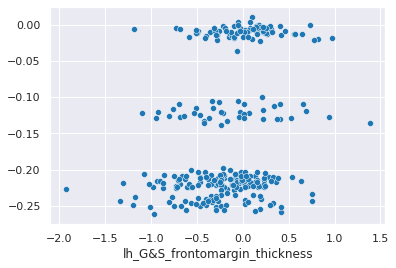

In [255]:
sns.scatterplot(diff[idp_ids[0]], posterior_predictive['y'].mean(axis=0))

array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

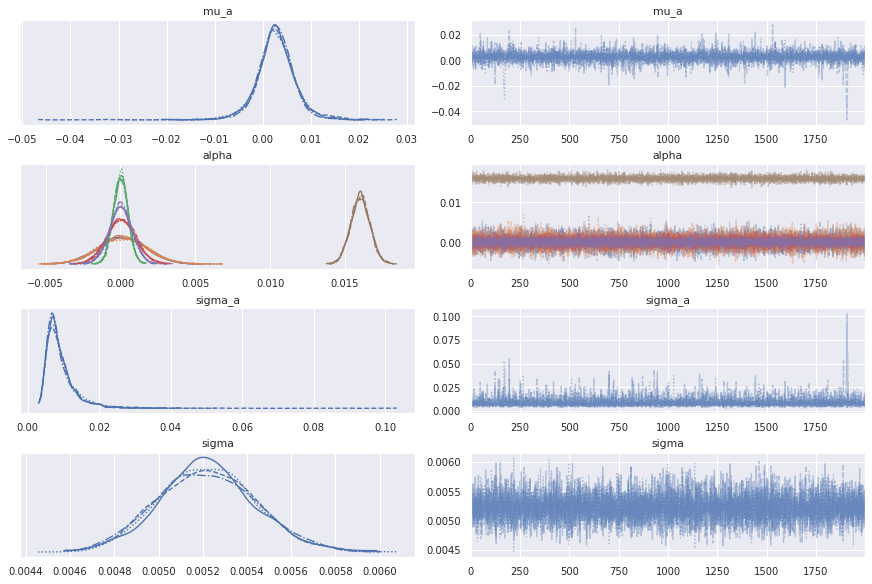

In [26]:
az.plot_trace(trace)

**Y_s^2 predictions**
-------------------

In [119]:
def concat_s2(target_dir, idp_ids, suffix='predict'):
    
    for i, idp in enumerate(idp_ids):

        # load precisions
        pk = np.genfromtxt(os.path.join(target_dir, idp, 'ys2_'+suffix +'.txt' ), delimiter=' ')
        pk = pk[:,np.newaxis]
                    
        if i==0:
            ys2 = pk
        else:
            ys2 = np.hstack([ys2, pk])

    ys2 = pd.DataFrame(ys2, columns=idp_ids)

    return(ys2)

In [122]:
# loadnig data
v1_fs = pd.read_csv(os.path.join(models_dir, 'V1', 'df_te.csv'), sep=' ', index_col=0)
v2_fs = pd.read_csv(os.path.join(models_dir, 'V2', 'df_te.csv'), sep=' ', index_col=0)

# loading ys2
target_dir = '/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/V1'
v1_ys2 = concat_s2(target_dir, idp_ids, suffix='predict')
target_dir = '/home/barbora/Documents/Projects/Normative_Models/COINS/models/threshold_50/V2'
v2_ys2 = concat_s2(target_dir, idp_ids, suffix='predict')

# concatenation
v1_ys2.index = v1_fs.index
v2_ys2.index = v2_fs.index

v1_ys2 = pd.concat([v1_ys2, v1_fs[['age', 'sex', 'site', 'sitenum']]], axis=1, join='inner')
v2_ys2 = pd.concat([v2_ys2, v2_fs[['age', 'sex', 'site', 'sitenum']]], axis=1, join='inner')

In [131]:
# load the uncertainties from ESO dataset
NUDZ_controls_dir = '/home/barbora/Documents/Projects/Normative_Models/ESO/models/control_stability_long'

# load the ESO controls data 
v1_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v1_cont.txt'), sep=' ', index_col=0)
v2_cont = pd.read_csv(os.path.join('/home/barbora/Documents/Projects/Normative_Models/ESO/analyses/01_PANSS/data','v2_cont.txt'), sep=' ', index_col=0)

# load across al idp's
for i, idp in enumerate(idp_ids):

        # load precisions
        v1_pk = np.genfromtxt(os.path.join(NUDZ_controls_dir, idp, 'v1_ys2.txt' ), delimiter=' ')
        v1_pk = v1_pk[:,np.newaxis]
                    
        v2_pk = np.genfromtxt(os.path.join(NUDZ_controls_dir, idp, 'v2_ys2.txt' ), delimiter=' ')
        v2_pk = v2_pk[:,np.newaxis]

        if i==0:
            v1_nudz = v1_pk
            v2_nudz = v2_pk
        else:
            v1_nudz = np.hstack([v1_nudz, v1_pk])
            v2_nudz = np.hstack([v2_nudz, v2_pk])
            
v1_nudz = pd.DataFrame(v1_nudz, index=v1_cont.index, columns=idp_ids)
v2_nudz = pd.DataFrame(v2_nudz, index=v2_cont.index, columns=idp_ids)


v1_nudz = pd.concat([v1_nudz,v1_cont[['sex','age','site']]], axis = 1, join='inner')
v2_nudz = pd.concat([v2_nudz,v2_cont[['sex','age','site']]], axis = 1, join='inner')

# add the ESO data to NUDZ dataset
v1_ys2 = pd.concat([v1_ys2, v1_nudz], axis=0, join='inner')
v2_ys2 = pd.concat([v2_ys2, v2_nudz], axis=0, join='inner')

v1_ys2 = v1_ys2.sort_values('site')
v2_ys2 = v2_ys2.sort_values('site')

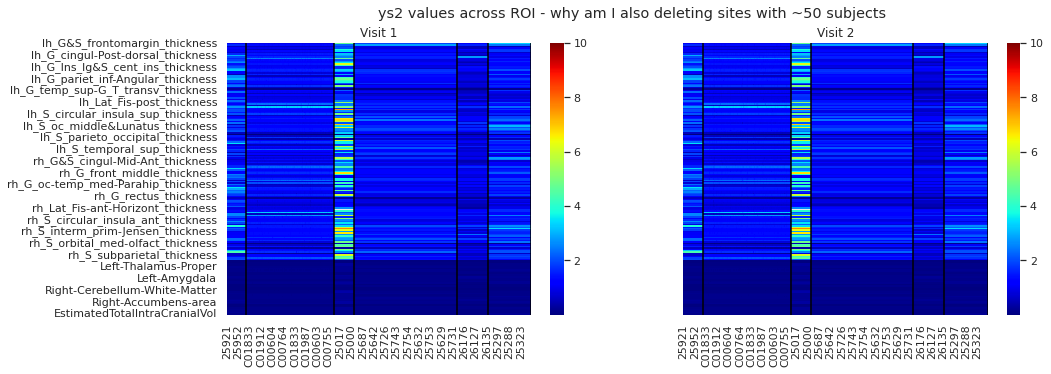

In [138]:
no_sites = v1_ys2['site'].value_counts().sort_index().cumsum()

fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
sns.heatmap(v1_ys2[idp_ids].T, cmap='jet', ax=ax[0], vmax=10)
ax[0].set_title('Visit 1')
sns.heatmap(v2_ys2[idp_ids].T, cmap='jet', ax=ax[1], vmax=10)
ax[1].set_title('Visit 2')
fig.suptitle('ys2 values across ROI - why am I also deleting sites with ~50 subjects')
for isite in no_sites:
    ax[0].axvline(isite, color='black')
    ax[1].axvline(isite, color='black')
plt.savefig(os.path.join(images_dir,'heatmap_why_am_I_deleting_sites_size_50'))

In [199]:
# remove sites with less than 35 test subjects
v1_small_sites = v1_ys2['site'].value_counts()[np.where(v1_ys2['site'].value_counts()<35)[0]].index
v2_small_sites = v2_ys2['site'].value_counts()[np.where(v2_ys2['site'].value_counts()<35)[0]].index
v1_ys2.drop(index=v1_ys2[v1_ys2['site'].isin(v1_small_sites)].index, inplace = True)
v2_ys2.drop(index=v2_ys2[v2_ys2['site'].isin(v2_small_sites)].index, inplace = True)

<AxesSubplot:>

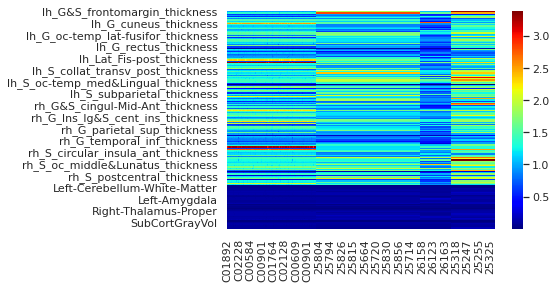

In [205]:
sns.heatmap(((v1_ys2[idp_ids]+v2_ys2[idp_ids])/2).T, cmap='jet')

In [209]:
((v1_ys2[idp_ids]+v2_ys2[idp_ids])/2).mean()

lh_G&S_frontomargin_thickness        1.724149
lh_G&S_occipital_inf_thickness       2.126403
lh_G&S_paracentral_thickness         0.711270
lh_G&S_subcentral_thickness          0.899358
lh_G&S_transv_frontopol_thickness    1.023560
                                       ...   
SubCortGrayVol                       0.108709
TotalGrayVol                         0.093768
SupraTentorialVol                    0.077781
SupraTentorialVolNotVent             0.077855
EstimatedTotalIntraCranialVol        0.087634
Length: 185, dtype: float64